In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
import numpy as np
from collections import namedtuple
import cv2
from pathlib import Path
import argparse
import os
import csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

from imblearn.over_sampling import SMOTE

In [4]:
folder_path_1 = "/content/drive/MyDrive/이상(방화)"
folder_path_2 = "/content/drive/MyDrive/이상(유기)"
folder_path_3 = "/content/drive/MyDrive/이상(전도)"
folder_path_4 = "/content/drive/MyDrive/이상(절도)"
folder_path_5 = "/content/drive/MyDrive/이상(파손)"
folder_path_6 = "/content/drive/MyDrive/이상(폭행)"
folder_path_7 = "/content/drive/MyDrive/이상(흡연)"
folder_path_8 = "/content/drive/MyDrive/구매(구매)"
folder_path_9 = "/content/drive/MyDrive/구매(반품)"
folder_path_10 = "/content/drive/MyDrive/구매(비교)"
folder_path_11 = "/content/drive/MyDrive/구매(선택)"

#folder_path_8 = "/content/drive/MyDrive/이상(교통약자)"
#folder_path_12 = "/content/drive/MyDrive/구매(시험)"

In [5]:
import os
import pandas as pd

def concat(path):
    file_lst = os.listdir(path)
    df_list = []

    for file in file_lst:
        file_name = os.path.join(path, file)
        df = pd.read_csv(file_name)
        df = df[df.NUMOFBODIES != 0].reset_index(drop=True)

        # 각 열을 순차적으로 뺍니다.
        for i in range(1, df.shape[1]-1):  # 첫 번째 열을 제외하고 시작
            # 변환: 문자열이 포함된 열을 숫자로 변환
            df[df.columns[i]] = pd.to_numeric(df[df.columns[i]], errors='coerce')
            df[df.columns[i+1]] = pd.to_numeric(df[df.columns[i+1]], errors='coerce')

            # 원래의 열에 연산 결과 할당
            df.loc[df.index[:-1], df.columns[i]] = df[df.columns[i]].iloc[1:].values - df[df.columns[i]].iloc[:-1].values

        df = df.iloc[:-1, :]

        # 길이가 610보다 짧은 경우 패딩 추가
        if len(df) < 610:
            pad_length = 610 - len(df)
            pad_df = pd.DataFrame(0, index=range(len(df), 610), columns=df.columns)
            df = pd.concat([df, pad_df])
        df['index_num'] = df.index

        df_list.append(df)

    return df_list


In [74]:
fire_mer = concat(folder_path_1)
yugi_mer = concat(folder_path_2)
jeon_mer = concat(folder_path_3)
theft_mer = concat(folder_path_4)
damage_mer = concat(folder_path_5)
violence_mer = concat(folder_path_6)
smoke_mer = concat(folder_path_7)
buy_mer = concat(folder_path_8)
refund_mer = concat(folder_path_9)
compar_mer = concat(folder_path_10)
select_mer = concat(folder_path_11)

#wheel_mer = concat(folder_path_8)
#test_mer = concat(folder_path_12)

In [75]:
buy_mer = pd.concat(buy_mer, ignore_index=True)
refund_mer = pd.concat(refund_mer, ignore_index=True)
compar_mer = pd.concat(compar_mer, ignore_index=True)
select_mer = pd.concat(select_mer, ignore_index=True)
fire_mer = pd.concat(fire_mer, ignore_index=True)
yugi_mer = pd.concat(yugi_mer, ignore_index=True)
jeon_mer = pd.concat(jeon_mer, ignore_index=True)
theft_mer = pd.concat(theft_mer, ignore_index=True)
damage_mer = pd.concat(damage_mer, ignore_index=True)
violence_mer = pd.concat(violence_mer, ignore_index=True)
smoke_mer = pd.concat(smoke_mer, ignore_index=True)

#test_mer = pd.concat(test_mer, ignore_index=True)
#wheel_mer = pd.concat(wheel_mer, ignore_index=True)

In [76]:
# 예측할 행위를 1, 나머지를 0으로 라벨링해서 모델 다 따로 생성하기
buy_mer['LABEL'] = 0
refund_mer['LABEL'] = 0
compar_mer['LABEL'] = 0
select_mer['LABEL'] = 0
fire_mer['LABEL'] = 0
yugi_mer['LABEL'] = 0
jeon_mer['LABEL'] = 0
theft_mer['LABEL'] = 0
damage_mer['LABEL'] = 0
violence_mer['LABEL'] = 0
smoke_mer['LABEL'] = 1

In [77]:
mer_lst = [fire_mer,
            yugi_mer,
            jeon_mer,
            theft_mer,
            damage_mer,
            violence_mer,
            smoke_mer,
           buy_mer,
           refund_mer,
           compar_mer,
           select_mer,
           ]
full_data = pd.concat(mer_lst, ignore_index=True)
full_data.shape

(3750890, 57)

In [78]:
full_data

,NUMOFBODIES,ID,PELVIS_X,PELVIS_Y,PELVIS_CONFIDENCE_LEVEL,SPINE_NAVAL_X,SPINE_NAVAL_Y,SPINE_NAVA_CONFIDENCE_LEVEL,SPINE_CHEST_X,SPINE_CHEST_Y,...,ANKLE_RIGHT_X,ANKLE_RIGHT_Y,ANKLE_RIGHT_CONFIDENCE_LEVEL,HEAD_X,HEAD_Y,HEAD_CONFIDENCE_LEVEL,TIMESTAMP,FRAME_NUM,index_num,LABEL
0,1,0,-32.5938,-2.11508,0,-36.4131,-1.53930,0,-39.6147,-0.92193,...,-13.1109,-6.73056,0,-46.2292,1.113250,0,NaN,100,0,0
1,1,0,-33.6850,15.69773,0,-32.9116,13.38342,0,-32.4573,11.50885,...,-35.0117,31.75769,0,-25.1343,7.242520,0,NaN,110,1,0
2,1,0,-34.5752,8.62304,0,-32.1521,7.37992,0,-30.0577,6.10119,...,-37.5166,-1.62879,0,-32.1066,2.461820,0,NaN,120,2,0
3,1,0,-36.7334,4.34464,0,-37.2742,3.29953,0,-37.4791,2.46360,...,-45.4725,19.32660,0,-38.2403,1.927100,0,NaN,130,3,0
4,1,0,-34.0015,6.84100,0,-37.2595,5.10513,0,-39.9591,3.28347,...,1.2446,5.93820,0,-42.7509,-2.554966,0,NaN,140,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750885,0,0,0.0000,0.00000,0,0.0000,0.00000,0,0.0000,0.00000,...,0.0000,0.00000,0,0.0000,0.000000,0,0.0,0,605,0
3750886,0,0,0.0000,0.00000,0,0.0000,0.00000,0,0.0000,0.00000,...,0.0000,0.00000,0,0.0000,0.000000,0,0.0,0,606,0
3750887,0,0,0.0000,0.00000,0,0.0000,0.00000,0,0.0000,0.00000,...,0.0000,0.00000,0,0.0000,0.000000,0,0.0,0,607,0
3750888,0,0,0.0000,0.00000,0,0.0000,0.00000,0,0.0000,0.00000,...,0.0000,0.00000,0,0.0000,0.000000,0,0.0,0,608,0


In [118]:
# 데이터와 레이블을 추출합니다
label_data = full_data['LABEL']
data_without_label = full_data.drop(columns=[col for col in full_data.columns if "CONFIDENCE_LEVEL" in col or "spin" in col.lower()])
#data_without_label = full_data.drop(columns=[col for col in full_data.columns if "CONFIDENCE_LEVEL" in col])
data_without_label = data_without_label.drop(['ID', 'TIMESTAMP', 'FRAME_NUM', 'LABEL', 'PELVIS_X', 'PELVIS_Y', 'NECK_X', 'NECK_Y'], axis=1)
#data_without_label = data_without_label.iloc[:, list(range(13)) + [-1]]



In [119]:
data_without_label.head(170)

,NUMOFBODIES,SHOULDER_LEFT_X,SHOULDER_LEFT_Y,ELBOW_LEFT_X,ELBOW_LEFT_Y,WRIST_LEFT_X,WRIST_LEFT_Y,SHOULDER_RIGHT_X,SHOULDER_RIGHT_Y,ELBOW_RIGHT_X,...,ANKLE_LEFT_Y,HIP_RIGHT_X,HIP_RIGHT_Y,KNEE_RIGHT_X,KNEE_RIGHT_Y,ANKLE_RIGHT_X,ANKLE_RIGHT_Y,HEAD_X,HEAD_Y,index_num
0,1,-37.8540,-4.547460,-22.5019,-5.49963,-16.4654,-5.60318,-43.3875,1.057980,-49.36180,...,-0.02902,-35.0265,0.77652,-24.8433,-0.90407,-13.1109,-6.73056,-46.2292,1.113250,0
1,1,-27.6200,16.104556,-23.2224,18.59457,-14.5153,21.43274,-31.4192,6.752630,-29.58590,...,26.66195,-34.3109,15.12878,-33.0279,20.83587,-35.0117,31.75769,-25.1343,7.242520,1
2,1,-31.6195,1.377960,-27.3044,2.73319,-32.8888,5.29877,-29.8080,4.184536,-38.59420,...,10.89363,-33.7527,6.29010,-47.1798,7.21289,-37.5166,-1.62879,-32.1066,2.461820,2
3,1,-34.9880,4.863124,-31.7000,1.25817,-32.3360,0.58179,-40.8441,3.635014,-37.70810,...,-8.50660,-37.8190,5.01184,-30.3491,8.40750,-45.4725,19.32660,-38.2403,1.927100,3
4,1,-39.2702,0.888860,-40.1894,10.13303,-31.6548,14.54233,-43.8344,-2.082190,-47.52784,...,20.20706,-35.3742,7.64576,-16.6838,9.51944,1.2446,5.93820,-42.7509,-2.554966,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1,21.6506,-1.984410,43.5508,-12.68537,34.2740,-13.62271,27.2716,5.302270,26.95360,...,-6.18750,21.6755,3.89471,9.5137,6.66254,1.6576,-3.08090,23.9756,12.652866,165
166,1,41.5616,-3.405670,5.4910,-1.90570,-17.1048,-16.17163,36.5797,4.389040,61.62360,...,-11.33114,29.9790,-1.90432,53.2445,-0.89784,48.8747,-7.96006,39.4758,6.224244,166
167,0,0.0000,0.000000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,...,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,167
168,0,0.0000,0.000000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,...,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,168


In [120]:
data_without_label.dtypes


NUMOFBODIES           int64
SHOULDER_LEFT_X     float64
SHOULDER_LEFT_Y     float64
ELBOW_LEFT_X        float64
ELBOW_LEFT_Y        float64
WRIST_LEFT_X        float64
WRIST_LEFT_Y        float64
SHOULDER_RIGHT_X    float64
SHOULDER_RIGHT_Y    float64
ELBOW_RIGHT_X       float64
ELBOW_RIGHT_Y       float64
WRIST_RIGHT_X       float64
WRIST_RIGHT_Y       float64
HIP_LEFT_X          float64
HIP_LEFT_Y          float64
KNEE_LEFT_X         float64
KNEE_LEFT_Y         float64
ANKLE_LEFT_X        float64
ANKLE_LEFT_Y        float64
HIP_RIGHT_X         float64
HIP_RIGHT_Y         float64
KNEE_RIGHT_X        float64
KNEE_RIGHT_Y        float64
ANKLE_RIGHT_X       float64
ANKLE_RIGHT_Y       float64
HEAD_X              float64
HEAD_Y              float64
index_num             int64
dtype: object

In [121]:
data_without_label

,NUMOFBODIES,SHOULDER_LEFT_X,SHOULDER_LEFT_Y,ELBOW_LEFT_X,ELBOW_LEFT_Y,WRIST_LEFT_X,WRIST_LEFT_Y,SHOULDER_RIGHT_X,SHOULDER_RIGHT_Y,ELBOW_RIGHT_X,...,ANKLE_LEFT_Y,HIP_RIGHT_X,HIP_RIGHT_Y,KNEE_RIGHT_X,KNEE_RIGHT_Y,ANKLE_RIGHT_X,ANKLE_RIGHT_Y,HEAD_X,HEAD_Y,index_num
0,1,-37.8540,-4.547460,-22.5019,-5.49963,-16.4654,-5.60318,-43.3875,1.057980,-49.36180,...,-0.02902,-35.0265,0.77652,-24.8433,-0.90407,-13.1109,-6.73056,-46.2292,1.113250,0
1,1,-27.6200,16.104556,-23.2224,18.59457,-14.5153,21.43274,-31.4192,6.752630,-29.58590,...,26.66195,-34.3109,15.12878,-33.0279,20.83587,-35.0117,31.75769,-25.1343,7.242520,1
2,1,-31.6195,1.377960,-27.3044,2.73319,-32.8888,5.29877,-29.8080,4.184536,-38.59420,...,10.89363,-33.7527,6.29010,-47.1798,7.21289,-37.5166,-1.62879,-32.1066,2.461820,2
3,1,-34.9880,4.863124,-31.7000,1.25817,-32.3360,0.58179,-40.8441,3.635014,-37.70810,...,-8.50660,-37.8190,5.01184,-30.3491,8.40750,-45.4725,19.32660,-38.2403,1.927100,3
4,1,-39.2702,0.888860,-40.1894,10.13303,-31.6548,14.54233,-43.8344,-2.082190,-47.52784,...,20.20706,-35.3742,7.64576,-16.6838,9.51944,1.2446,5.93820,-42.7509,-2.554966,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750885,0,0.0000,0.000000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,...,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,605
3750886,0,0.0000,0.000000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,...,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,606
3750887,0,0.0000,0.000000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,...,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,607
3750888,0,0.0000,0.000000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,...,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.000000,608


In [122]:
sequence_start_indices = full_data.index[full_data['index_num'] == 0].tolist()
sequence_lengths = [sequence_start_indices[i] - sequence_start_indices[i-1] for i in range(1, len(sequence_start_indices))]
sequence_lengths.insert(0, sequence_start_indices[0])

# Min sequence length
min_sequence_length = min(sequence_lengths)

In [123]:
min_sequence_length = 610

In [124]:
X_sequences = []
y_sequences = []

# Iterating over the start indices to create sequences
for i in range(len(sequence_start_indices) - 1):
    start_index = sequence_start_indices[i]
    end_index = sequence_start_indices[i + 1]

    # Ensure the sequence has the expected length before appending
    if end_index - start_index == min_sequence_length:
        X_sequence = data_without_label.iloc[start_index:end_index].values
        y_sequence = label_data.iloc[start_index:end_index].values
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence[-1])  # Taking the label of the last frame for the sequence

# Converting lists to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_sequences.shape, y_sequences.shape


((6148, 610, 28), (6148,))

In [125]:
y_sequences

array([0, 0, 0, ..., 0, 0, 0])

In [126]:
# Check the unique values and their frequencies in y_sequences
y_unique_values, y_counts = np.unique(y_sequences, return_counts=True)

y_unique_values, y_counts


(array([0, 1]), array([5376,  772]))

In [127]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=48)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=48)

In [128]:
X_train.shape

(4303, 610, 28)

In [130]:
## 오버샘플링 (SMOTE)
#  - 2차원 이하 차원만 가능

# 학습데이터 차원 낮추기 (3차원 -> 2차원)
# X_train.shape -> (4303, 610, 28)
X_train = X_train.reshape(4303, 610 * 28)

# SMOTE를 적용할 때는 반드시 !!학습 데이터!!만 오버샘플링해야 함
smote = SMOTE(random_state=48)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

X_smote.shape, y_smote.shape

((7586, 17080), (7586,))

In [131]:
# 원래대로 차원 늘리기 (2차원 -> 3차원)
# X_smote의 변경된 데이터 개수로 바꿔주기
# - 행위마다 오버샘플링 시 데이터 개수가 다름
X_smote = X_smote.reshape(7586, 610, 28)

In [132]:
X_train.shape, X_smote.shape

((4303, 17080), (7586, 610, 28))

In [133]:
print(X_train.shape, y_train.shape)

(4303, 17080) (4303,)


In [134]:
print(X_temp.shape, y_temp.shape)

(1845, 610, 28) (1845,)


In [135]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

X_smote = X_smote.astype(np.float32)
y_smote = y_smote.astype(np.float32)

In [136]:
### 실행결과 동일하게(완전 일치하지는 않음)
tf.keras.utils.set_random_seed(42)
### 텐서 연산 고정(완전 일치하지는 않음)
tf.config.experimental.enable_op_determinism()

In [144]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_smote.shape[1], X_smote.shape[2])),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련 데이터에 대한 샘플 가중치 마스크 생성
# 패딩이 아닌 값은 1, 패딩된 값은 0
sample_weight_train = np.where(X_smote != 0, 1, 0)
sample_weight_train = sample_weight_train.max(axis=-1)

# 각 시퀀스에 대한 평균 샘플 가중치 계산
sample_weight_train_avg = sample_weight_train.mean(axis=1)

In [145]:
# !!!!!행위마다 모델 이름 변경하기!!!!!
model_file_path = '/content/drive/MyDrive/model/smoke_last.h5'
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path, save_best_only = True)
# - 자동 훈련 멈추기 함수 사용 : 추가 훈련 epoch 3회, 가중치 업데이트
# - patience : 검증 손실의 최소값에 도달한 후 중단하기 전에 기다려야 하는 epoch 수
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3,
                                        restore_best_weights=True)


# 모델 훈련
history = model.fit(X_smote, y_smote, validation_data=(X_val, y_val), epochs=100,
                    batch_size=128, sample_weight=sample_weight_train_avg,
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/100
60/60 [==============================] - 7s 66ms/step - loss: 0.6796 - accuracy: 0.5633 - val_loss: 0.8153 - val_accuracy: 0.4756
Epoch 2/100
60/60 [==============================] - 3s 43ms/step - loss: 0.4901 - accuracy: 0.7727 - val_loss: 0.3395 - val_accuracy: 0.8807
Epoch 3/100
60/60 [==============================] - 3s 43ms/step - loss: 0.3951 - accuracy: 0.8401 - val_loss: 0.5507 - val_accuracy: 0.7498
Epoch 4/100
60/60 [==============================] - 3s 43ms/step - loss: 0.3087 - accuracy: 0.8870 - val_loss: 0.3264 - val_accuracy: 0.8854
Epoch 5/100
60/60 [==============================] - 3s 43ms/step - loss: 0.2461 - accuracy: 0.9144 - val_loss: 0.2796 - val_accuracy: 0.9024
Epoch 6/100
60/60 [==============================] - 3s 44ms/step - loss: 0.1972 - accuracy: 0.9322 - val_loss: 0.2628 - val_accuracy: 0.9086
Epoch 7/100
60/60 [==============================] - 3s 44ms/step - loss: 0.1691 - accuracy: 0.9425 - val_loss: 0.2458 - val_accuracy: 0.9233
Epoch 

In [146]:
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/model/smoke_last.h5')

In [147]:
X_sequences, y_sequences
X_val = X_sequences.astype(np.float32)
y_val = y_sequences.astype(np.float32)

In [148]:
# 유니크한 종속변수들을 얻습니다.
unique_targets = np.unique(y_val)

# 테스트 데이터에 대한 예측을 한 번만 수행
test_preds = model1.predict(X_val)
test_pred_idx = [np.argmax(pred) for pred in test_preds]

193/193 [==============================] - 4s 15ms/step


In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


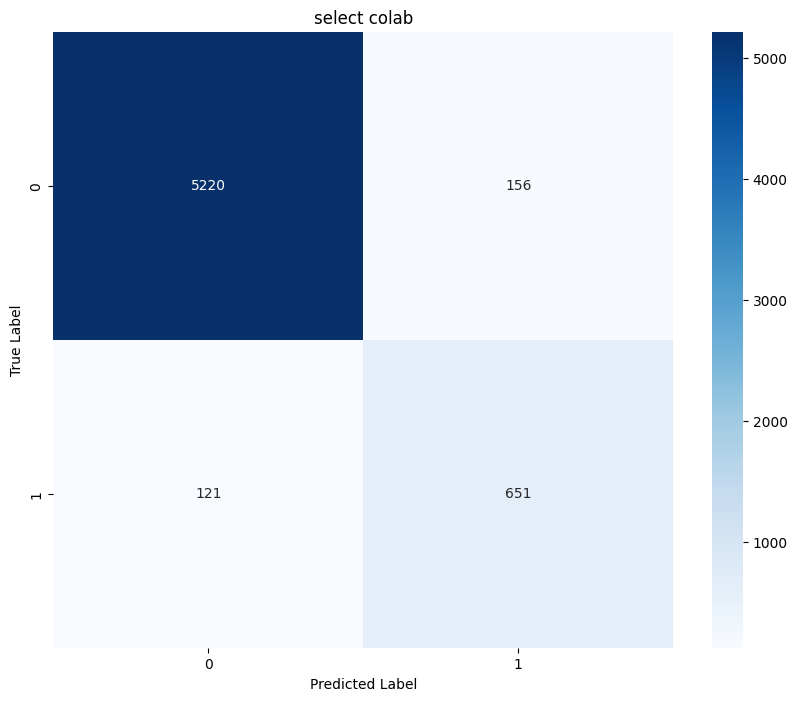

F1 Score: 0.9553704720648529

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      5376
         1.0       0.81      0.84      0.82       772

    accuracy                           0.95      6148
   macro avg       0.89      0.91      0.90      6148
weighted avg       0.96      0.95      0.96      6148



In [150]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 실제 레이블과 예측 레이블을 사용하여 Confusion Matrix를 계산합니다.
conf_matrix = confusion_matrix(y_val, test_pred_idx)

# F1 Score를 계산합니다.
f1 = f1_score(y_val, test_pred_idx, average='weighted')

# Confusion Matrix를 시각화합니다.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('select colab')
plt.show()

# 결과를 출력합니다.
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_val, test_pred_idx))
